In [147]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from skimage import io
from scipy import ndimage as ndi
from skimage import feature
from skimage.filters import gaussian
from skimage.filters import sobel
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist
from skimage.exposure import rescale_intensity
from skimage.feature import canny
from scipy.ndimage.morphology import binary_fill_holes
from skimage.measure import label
from skimage.measure import regionprops
import pandas as pd

from scipy.optimize import curve_fit
import sympy
from sympy import *

In [25]:
# Replace this with the path to battdeg.py module in your system
sys.path.insert(0, '/Users/sages/Desktop/DataScience/musical-robot/musicalrobot')

In [26]:
import irtemp

In [27]:
frames = io.imread('../doc/PPA_Melting_6_14_19.tiff')

#### Flipping all the frames horizontally and vertically to correct for the mirroring during recording

In [28]:
flip_frame = []
for frame in frames:    
    f_frame = np.fliplr(frame)
    flip_frame.append(np.flipud(f_frame))

In [29]:
len(frames)

1619

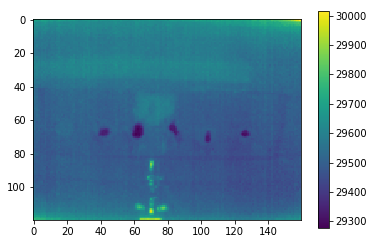

In [30]:
plt.imshow(frames[0])
plt.colorbar()


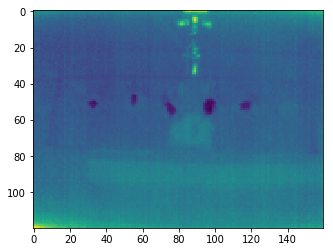

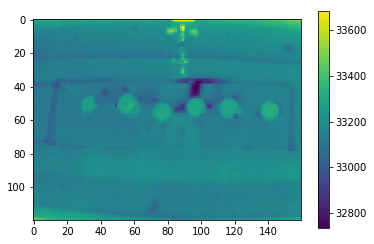

In [31]:
plt.imshow(flip_frame[0])
plt.show()
plt.imshow(flip_frame[1500])
plt.colorbar()

In [32]:
for i in range(len(flip_frame[0])):
    frame = frame[40:80]

In [33]:
crop_frame = []
for frame in flip_frame:
    crop_frame.append(frame[40:100])

In [34]:
edges = feature.canny(crop_frame[0]/1500)


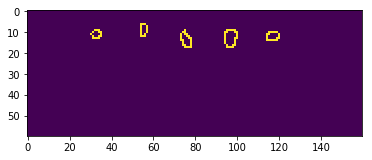

In [35]:
plt.imshow(edges)

In [36]:
from skimage.morphology import remove_small_objects   
filled_wells = binary_fill_holes(edges)
cl_wells = remove_small_objects(filled_wells,min_size=20)
labeled_wells = label(cl_wells)

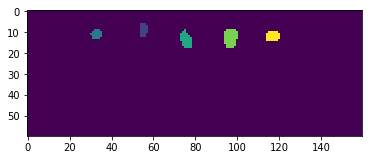

In [37]:
plt.imshow(labeled_wells)

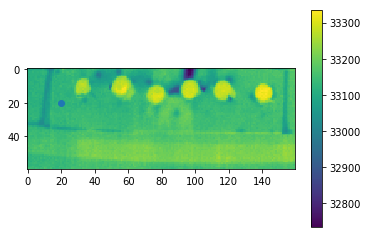

In [38]:
plt.imshow(crop_frame[1500])
plt.colorbar()
plt.scatter(20,20)

In [39]:
frames[0][20][100]

29577

In [40]:
regprops = {} 
for i in range(len(crop_frame)):
    props = regionprops(labeled_wells, intensity_image=crop_frame[i])
    x = np.zeros(len(props)).astype(int)
    y = np.zeros(len(props)).astype(int)
    area = np.zeros(len(props))
    perim = np.zeros(len(props))
    intensity = np.zeros(len(props),dtype=np.float64)

    c = 0
    for prop in props:
        x[c] = int(prop.centroid[0])
        y[c] = int(prop.centroid[1])
        #print(y[c])
        area[c] = prop.area
        perim[c] = prop.perimeter
        intensity[c] = crop_frame[i][x[c]][y[c]]
        c = c + 1

    regprops[i] = pd.DataFrame({'X': x, 'Y': y, 'Area': area,
                            'Perim': perim, 'Mean Intensity': intensity},dtype=np.float64)

In [41]:
for i in range(len(crop_frame)):
    if len(regprops[i]) != 5:
        print('Wrong number of samples')
        print(i)

In [42]:
sample_temp = []
for j in range(5):
    temp_well = []
    for i in range(len(crop_frame)):
        temp_well.append(irtemp.centikelvin_to_celsius(regprops[i]['Mean Intensity'][j]))
    sample_temp.append(temp_well)   

In [43]:
len(sample_temp)

5

In [44]:
len(sample_temp[0])

1619

## Temperature of the plate

In [45]:
plate_temp = []
for i in range(len(crop_frame)):
    plate_temp.append(irtemp.centikelvin_to_celsius(crop_frame[i][20][20]))
    

In [46]:
len(plate_temp)

1619

Text(0, 0.5, 'Temperature of the PPA sample($^\\circ$C)')

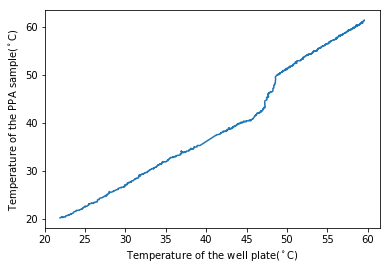

In [212]:
plt.plot(plate_temp,sample_temp[4])
plt.xlabel('Temperature of the well plate($^\circ$C)')
plt.ylabel('Temperature of the PPA sample($^\circ$C)')

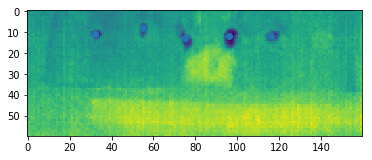

In [48]:
plt.imshow(crop_frame[0])
plt.scatter(y,x)

# Pulling the approximate inflection point from the plot

In [213]:
y = sample_temp[4]
x = plate_temp

x = np.array(x, dtype = float)
y = np.array(y, dtype = float)

def func(x,a, b,c,d,e):
    return a*x**4+ b*x**3 + c*x**2 + d*x + e

popt,pcov = curve_fit(func, x, y)
print(popt)

[-8.77353564e-05  1.42701416e-02 -8.30862688e-01  2.15091873e+01
 -1.84055628e+02]


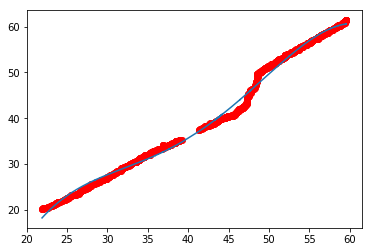

In [214]:
plt.plot(x,y, 'ro', label = "Data")
plt.plot(x, func(x, *popt), label = "fitted")

### Shortening the sample zone

In [309]:
y = sample_temp[4]
x = plate_temp
index = 0
jump = 15
all_slope = []
all_index = []

while index < len(y):
    slope = (y[index]-y[index + jump])/(x[index]-x[index + jump])
    #print(slope)
    index = index + jump
    if index >= len(y) - jump:
        break
   
    all_slope.append(slope)
    all_index.append(index)
print(all_slope)

[0.5405405405405371, 0.5308641975308647, 1.1698113207547163, 0.5810810810810819, 0.8923076923076868, 1.3913043478260965, 0.3606557377049165, 1.1803278688524572, 0.8620689655172439, 1.255813953488371, 1.0454545454545443, 0.7246376811594227, 0.7999999999999967, 0.8999999999999986, 1.2857142857142916, 1.0227272727272763, 1.022727272727268, 1.0363636363636355, 1.8571428571428825, 0.8, 0.8627450980392216, 1.0999999999999943, 0.7199999999999989, 1.419354838709671, 0.6428571428571392, 1.5200000000000102, 0.3400000000000034, 1.852941176470595, 0.6176470588235258, 0.35294117647058454, 0.5272727272727346, 3.4210526315789807, -0.04000000000000625, 0.6756756756756803, 0.9687500000000062, 1.0606060606060475, 0.3142857142857178, 1.02822580645161, 0.9743589743589703, 0.6086956521739144, 0.4782608695652214, 0.9166666666666831, 0.4374999999999917, 1.1666666666666587, 0.9729729729729781, 1.2222222222221697, 0.4545454545454741, 0.8333333333333086, -0.10000000000000474, 1.1052631578947545, 0.2500000000000

In [217]:
yposs =[]
xposs = []
for i in range(len(all_slope)):
    upbound = 2*np.std(all_slope) + np.mean(all_slope)
    downbound = np.mean(all_slope) - 2 * np.std(all_slope) 
    if all_slope[i] < downbound:
        yposs.append(all_slope[i])
        yposs.append(allx[i])
    elif all_slope[i] > upbound:
        yposs.append(all_slope[i])
        xposs.append(allx[i])
    else:
        pass
    
print(xposs)

[848, 944, 1152, 1328]


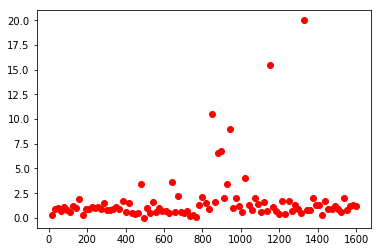

In [218]:
plt.plot(allx,all_slope, 'ro', label = "Data")4

In [284]:
lowrange = int(min(xposs) - jump)
highrange = int(max(xposs))

print(lowrange, highrange)

810 1328


### Smoothing to find max slope

In [319]:
smoothed = []
againx = []
jump = 5
for i in range(len(all_slope)):
    smoothed.append(sum(all_slope[i:i+jump])/jump)
    againx.append(sum(allx[i:i+jump])/jump)
print(smoothed)

[0.8706989996548188, 0.9241216413017869, 0.9296797385624703, 0.9566054519543717, 0.9678973886682654, 0.9694670513840228, 0.9576924769415894, 0.9588428036849276, 0.9573574363527992, 0.9805397292293151, 1.0404904950122358, 1.079816676077548, 1.1136526610644288, 1.138655971479505, 1.14155019098549, 1.0886471754684313, 1.04888701709423, 1.041816341785982, 1.0012547573868258, 1.0186653655010385, 1.0215191831571342, 1.019062076443482, 0.9506056827423072, 1.035791394304291, 0.9999418117486272, 0.998481685062495, 1.0332505499730023, 1.1290618391259328, 0.9773603463239737, 0.9441055328389035, 0.9204769066270785, 0.8578137535610333, 0.7505234595200221, 0.7915990802659804, 0.7663166364958091, 0.7367791684706138, 0.7362149671904247, 0.7887030276581466, 0.7986110015457815, 0.8479813410248138, 0.838992706144872, 0.8207245858298389, 0.7338091225196417, 0.7057681180839015, 0.7102271136481628, 0.8197875584877871, 0.9209887267576068, 1.1310787839163106, 1.2894805293867049, 1.487537447270892, 1.775010514

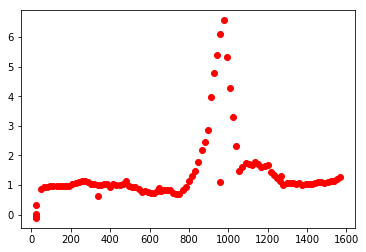

In [320]:
plt.plot(againx,smoothed, 'ro', label = "Data")

In [332]:
np.max(smoothed)

for i in range(len(smoothed)):
    if smoothed[i] == np.max(smoothed):
        print(againx[i])
        index = int(againx[i])
        print(y[index])
        break
    else:
        pass
    


976.0
50.4


In [321]:
yposs =[]
xposs = []
all_slope = smoothed

for i in range(len(all_slope)):
    upbound = 2*np.std(all_slope) + np.mean(all_slope)
    downbound = np.mean(all_slope) - 2 * np.std(all_slope) 
    if all_slope[i] < downbound:
        yposs.append(all_slope[i])
        yposs.append(allx[i])
    elif all_slope[i] > upbound:
        yposs.append(all_slope[i])
        xposs.append(againx[i])
    else:
        pass
    
print(xposs)
check = int(np.mean(xposs))
print(check)

[912.0, 928.0, 944.0, 960.0, 976.0, 992.0, 1008.0]
960


In [322]:
print(y[check])

50.1


In [247]:
index = lowrange
end = highrange
jump = 10
all_slope = []
allx = []

while index < end:
    slope = (y[index -1] + 2*y[index] - y[index + jump])/(2*(x[index]-x[index + jump]))
    #print(slope)
    index = index + jump
    if index >= len(y) - jump:
        break
    all_slope.append(slope)
    xval = x[index]
    allx.append(xval)
    
print(all_slope)

[-249.7058823529387, -110.776315789475, 853.6000000000483, -198.7272727272738, -213.88095238095156, -649.8571428571404, -230.5749999999967, -106.74418604651167, -473.4000000000269, -474.3999999999932, -197.67999999999995, -263.2105263157828, -294.6764705882447, -628.9374999999575, -209.79166666667112, -202.52, -340.73333333333653, -366.17857142856997, -170.7999999999976, 1715.9999999999352, -147.571428571428, -1293.8750000000277, -157.3787878787887, -290.55555555555594, 1049.0000000000593, -238.97727272727397, -170.6451612903213, -408.0000000000142, -265.82499999999624, 1065.6999999999093, -764.8571428571398, -233.0869565217351, -298.8333333333338, -234.80434782609012, -775.4999999999968, -164.56060606060333, -302.30555555555605, -121.9555555555567, 1097.5000000000623, -305.3611111111116, -1108.1000000000631, -213.36538461538626, -213.40384615384198, -328.7058823529379, -311.0555555555561, -1124.2000000000637, -144.47435897435875, 1882.833333333262, -378.7333333333368]


In [258]:
all_slope2 = []
index = 0
end = len(all_slope)
jump = 12
lastsave = 0
inflection = []


while index < end - 1:
    if index >= len(all_slope) - jump:
        break
    slope = (all_slope[index - jump] + 2*all_slope[index] - all_slope[index + jump])/(2*(x[index]-x[index + jump]))
    #print(slope)
    if slope * lastsave != abs(slope * lastsave):
        inflection.append(index * jump)
    else:
        pass        

    lastsave = slope
    
    all_slope2.append(slope)
    
    xval = x[index]
    allx.append(xval)
    index = index + jump
    
print(all_slope2)
print(inflection)
print(y[inflection[0]])

[-0.06372549019607546, -0.9871895424836602, -1.7182158119657898, -0.6844604863222225, -1.285962301587298, -4.072802197802189, -4.024943310657583, -1.9618453441983263]
[]


IndexError: list index out of range

In [ ]:
while index < len(y):
    slope = (y[index]-y[index + jump])/(x[index]-x[index + jump])
    #print(slope)
    index = index + jump
    if index >= len(y) - jump:
        break
    all_slope.append(slope)
    xval = index
    allx.append(xval)
    
while index < end - 1:
    slope = (all_slope[index - jump] + 2*all_slope[index] - all_slope[index + jump])/(2*(x[index]-x[index + jump]))
    #print(slope)
    if slope * lastsave != abs(slope * lastsave):
        inflection = index
    else:
        pass        
    if index >= len(all_slope) - jump:
        break
    lastsave = slope
    all_slope2.append(slope)
    xval2 = x[index]
    allx2.append(xval)
    index = index + jump
    
    

In [1]:
    sample_temp = [[3,5,6,7,2,7,2,4], [4,1,6,7,2,4,6,1]]

In [ ]:
sample_temp = sample_temp[0]